In [1]:
# install necessary Library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [3]:
# Mount google drive and load the data
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/Colab Notebooks/nature_12K/inaturalist_12K/train"

Mounted at /content/drive


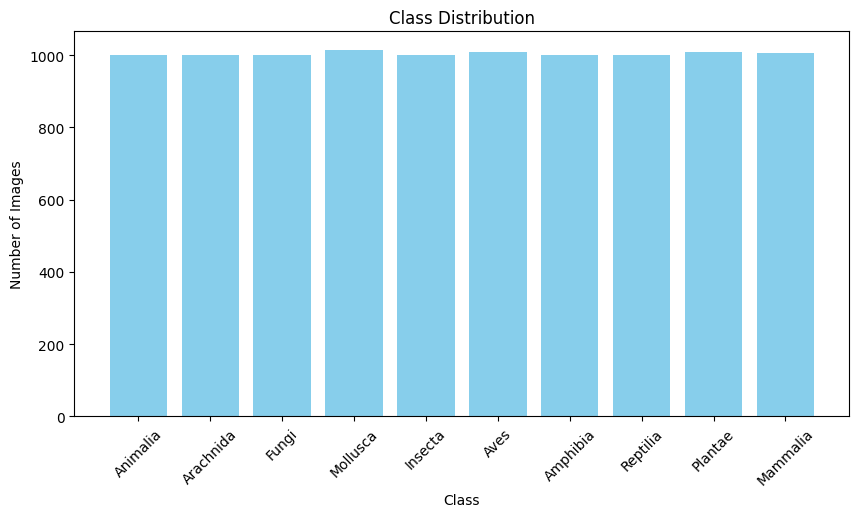

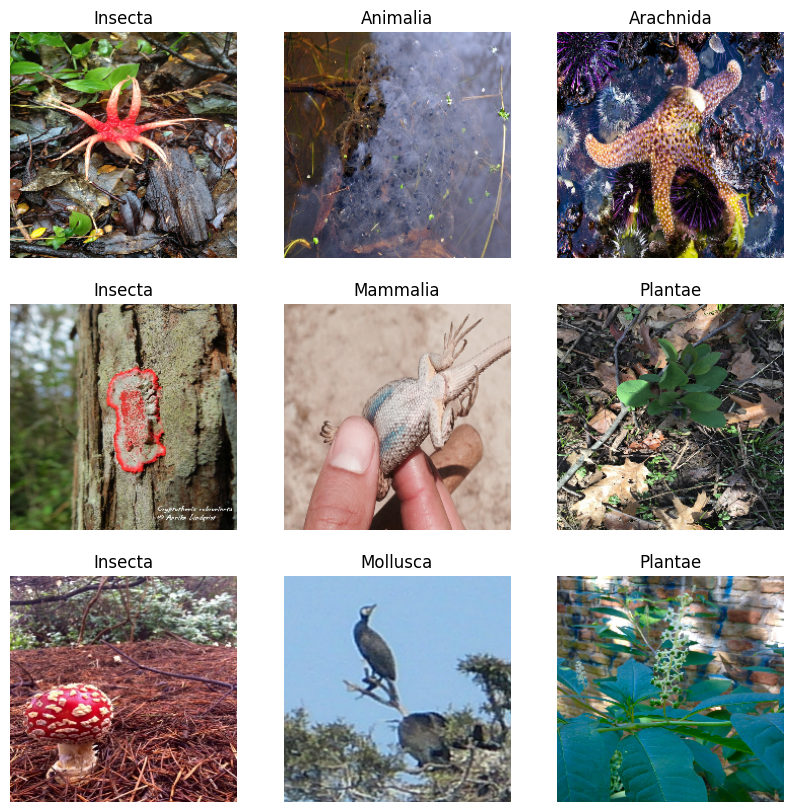

In [30]:
# Exploratory Data Analysis
# Check class distribution
import os
import matplotlib.pyplot as plt


class_names = os.listdir(dataset_path)
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in class_names}

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

# Visualize sample images
def visualize_sample_images(dataset, class_names):
    images, labels = next(iter(dataset))
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = images[i].numpy()
        img = (img * 255).astype("uint8") if img.max() <= 1 else img
        plt.imshow(img)
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

    plt.show()

visualize_sample_images(train_ds, class_names)


In [31]:
# check image dimension

import tensorflow as tf

def check_image_shapes(dataset, num_samples=5):
    images, labels = next(iter(dataset))  # Get a batch of images
    print(f"Checking first {num_samples} images...\n")

    for i in range(min(num_samples, len(images))):
        img = images[i].numpy()  # Convert tensor to NumPy array
        print(f"Image {i+1} shape: {img.shape}")  # Print shape info

check_image_shapes(train_ds)


Checking first 5 images...

Image 1 shape: (224, 224, 3)
Image 2 shape: (224, 224, 3)
Image 3 shape: (224, 224, 3)
Image 4 shape: (224, 224, 3)
Image 5 shape: (224, 224, 3)


In [5]:
# Split the dataset
dataset = keras.utils.image_dataset_from_directory(
    dataset_path,
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Get class names
class_names = dataset.class_names
print(f"Classes: {class_names}")

# Split dataset into 90% train and 10% validation
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

print(f"Training samples: {len(train_ds)}, Validation samples: {len(val_ds)}")


Found 10039 files belonging to 10 classes.
Classes: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']
Training samples: 282, Validation samples: 32


In [39]:
def compute_mean_std(dataset, num_samples=100):
    pixel_values = []
    # Get a batch of images first to get the image shape
    images, _ = next(iter(dataset))

    for _, _ in dataset.take(num_samples // images.shape[0]):  # Process multiple batches
        # Get a batch of images in each iteration
        images, _ = next(iter(dataset))
        images_np = images.numpy()  # Convert tensor to NumPy array
        pixel_values.append(images_np)

    pixel_values = np.concatenate(pixel_values, axis=0)  # Combine all images
    mean = np.mean(pixel_values)  # Compute mean
    std = np.std(pixel_values)  # Compute standard deviation

    print(f"Mean Pixel Value: {mean:.4f}")
    print(f"Standard Deviation of Pixel Values: {std:.4f}")

# Compute mean and standard deviation of pixel values in the training dataset
compute_mean_std(train_ds)

Mean Pixel Value: 0.4272
Standard Deviation of Pixel Values: 0.2418


In [6]:
# Data Normalization and Augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


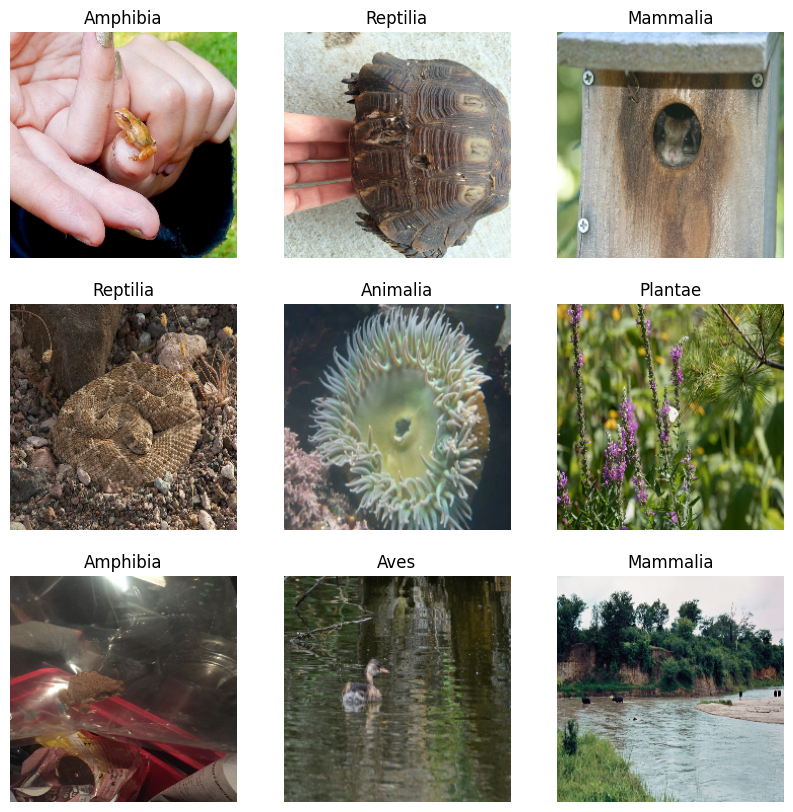

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample_images(dataset, class_names):
    images, labels = next(iter(dataset))  # Get a batch of images and labels
    plt.figure(figsize=(10, 10))

    for i in range(min(9, len(images))):  # Ensure we don't exceed batch size
        plt.subplot(3, 3, i + 1)

        img = images[i].numpy()
        if img.max() <= 1:  # If normalized, scale back to 0-255
            img = (img * 255).astype("uint8")

        plt.imshow(img)
        plt.title(class_names[int(labels[i])])  # Get class name
        plt.axis("off")

    plt.show()

visualize_sample_images(train_ds, class_names)


In [7]:
base_model = keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # Freeze base model


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Hyperparameter Tuning
dropout_rate = 0.4
learning_rate = 0.0005

model = keras.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(dropout_rate),
    layers.Dense(256, activation="relu"),
    layers.Dropout(dropout_rate),
    layers.Dense(len(class_names), activation="softmax")
])

# Compile Model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [10]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    save_best_only=True
)


In [11]:
#   Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1543s 5s/step - accuracy: 0.1001 - loss: 2.3453 - val_accuracy: 0.0926 - val_loss: 2.3039
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1068s 4s/step - accuracy: 0.0888 - loss: 2.3052 - val_accuracy: 0.0936 - val_loss: 2.3036
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1104s 4s/step - accuracy: 0.0979 - loss: 2.3035 - val_accuracy: 0.0936 - val_loss: 2.3045
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1105s 4s/step - accuracy: 0.0995 - loss: 2.3050 - val_accuracy: 0.0946 - val_loss: 2.3029
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1113s 4s/step - accuracy: 0.1002 - loss: 2.3030 - val_accuracy: 0.0946 - val_loss: 2.3028
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1054s 4s/step - accuracy: 0.0968 - loss: 2.3029 - val_accuracy: 0.0985 - val_loss: 2.3029
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1117s 4s/step - accuracy: 0.1000 - loss: 2.3028 - val_accuracy: 0.0956 - val_loss: 2.3030
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1069s 4s/step - accuracy: 0.1017 - loss: 2.3028 - 

In [12]:
# Fine Tuning
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 3197s 11s/step - accuracy: 0.2400 - loss: 2.2308 - val_accuracy: 0.2552 - val_loss: 2.1017
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 3116s 11s/step - accuracy: 0.5704 - loss: 1.2871 - val_accuracy: 0.1488 - val_loss: 2.2902
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 3157s 11s/step - accuracy: 0.6670 - loss: 1.0159 - val_accuracy: 0.3478 - val_loss: 1.9193
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 3112s 11s/step - accuracy: 0.7174 - loss: 0.8695 - val_accuracy: 0.3182 - val_loss: 1.9983
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 3166s 11s/step - accuracy: 0.7408 - loss: 0.7799 - val_accuracy: 0.4946 - val_loss: 1.5305
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 3174s 11s/step - accuracy: 0.7664 - loss: 0.7243 - val_accuracy: 0.4867 - val_loss: 1.6937
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 3199s 11s/step - accuracy: 0.7868 - loss: 0.6442 - val_accuracy: 0.2552 - val_loss: 2.2294
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 3141s 11s/step - accuracy: 0.8189 - loss: 0

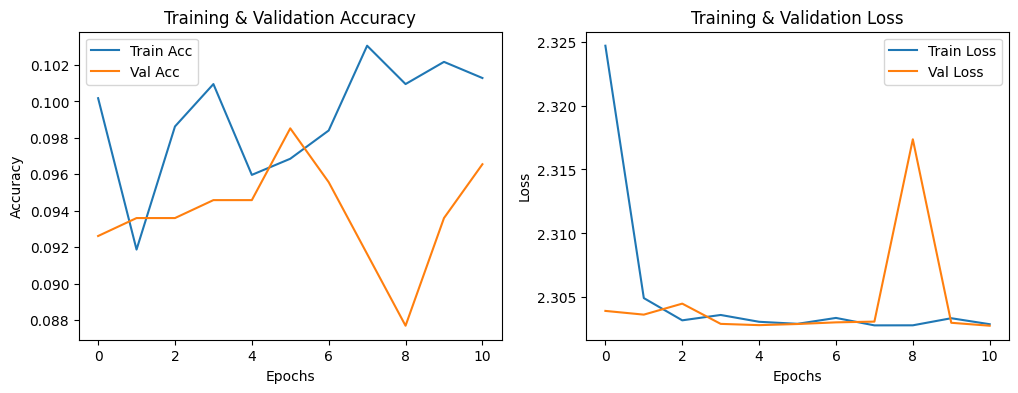

In [13]:
#lot accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training & Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")

    plt.show()

plot_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

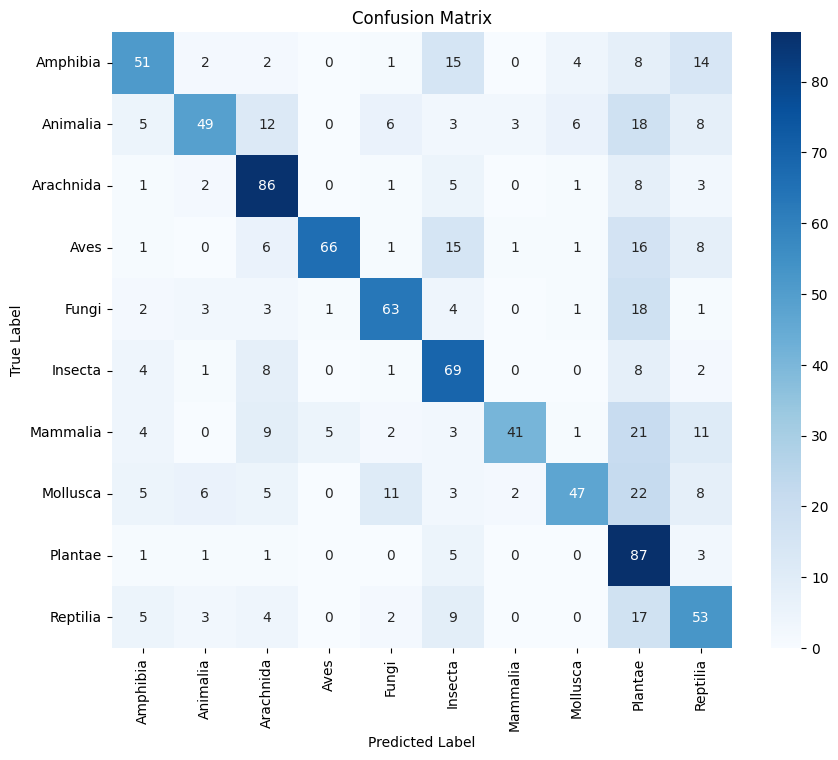

In [25]:
!pip install seaborn
import seaborn as sns # Import seaborn for heatmap
from sklearn.metrics import confusion_matrix # Import the confusion_matrix function

def plot_confusion_matrix(model, dataset):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, val_ds)


In [14]:
# Test the model on sepeate test set
test_path = "/content/drive/MyDrive/Colab Notebooks/nature_12K/inaturalist_12K/val"  # Update with actual path

test_ds = keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(224, 224),
    batch_size=32
)

# Normalize test data
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Evaluate performance on test data
test_loss, test_acc = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_acc:.4f}")

# Save final model
model.save("final_image_classifier.keras")


Found 2004 files belonging to 10 classes.
63/63 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.5905 - loss: 1.3523
Final Test Accuracy: 0.5953


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


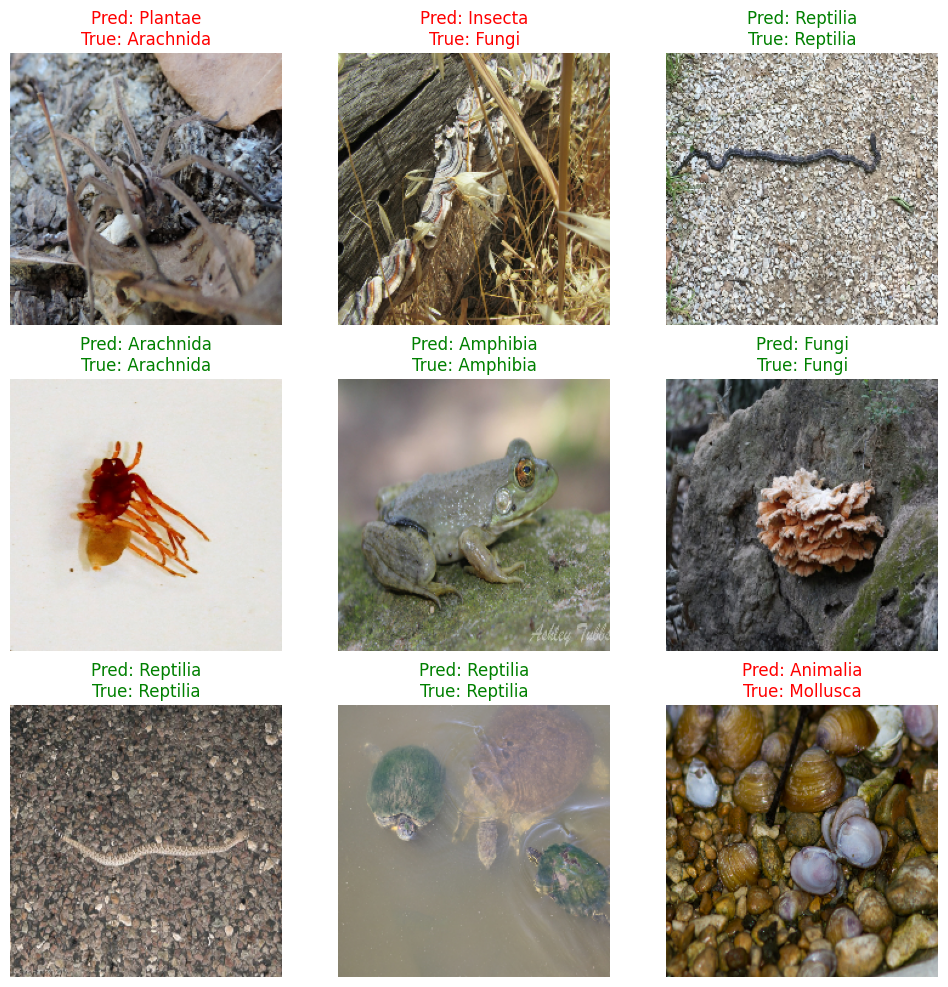

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, class_names):
    images, labels = next(iter(dataset))  # Get a batch of images and labels
    predictions = model.predict(images)  # Make predictions
    predicted_labels = np.argmax(predictions, axis=1)  # Get predicted classes

    plt.figure(figsize=(12, 12))

    for i in range(min(9, len(images))):  # Show up to 9 images
        plt.subplot(3, 3, i + 1)

        # Convert image back to 0-255 range for proper display
        img = images[i].numpy()
        img = (img * 255).astype("uint8")  # Rescale pixel values

        plt.imshow(img)
        title_color = "green" if predicted_labels[i] == labels[i].numpy() else "red"
        plt.title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {class_names[int(labels[i])]}",
                  color=title_color)
        plt.axis("off")

    plt.show()

visualize_predictions(model, test_ds, class_names)


In [18]:
# rediction on new image
from PIL import Image

def predict_image(image_path):
    img = Image.open("/content/drive/MyDrive/Colab Notebooks/nature_12K/inaturalist_12K/tiger.jpg").resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    print(f"Predicted Class: {class_names[predicted_class]}")

predict_image("path_to_test_image.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: Mammalia
